In [1]:
import keras.models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import os


def relative_strength_index(df, n=14):
    """Calculate Relative Strength Index(RSI) for given data.

    :param df: pandas.DataFrame
    :param n:
    :return: pandas.DataFrame
    """
    i = 0
    UpI = [0]
    DoI = [0]
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'High'] - df.loc[i, 'High']
        DoMove = df.loc[i, 'Low'] - df.loc[i + 1, 'Low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
    RSI = pd.Series(PosDI / (PosDI + NegDI), name='RSI_' + str(n))
    return RSI


def macd(df, n_fast=26, n_slow=12):
    """Calculate MACD, MACD Signal and MACD difference

    :param df: pandas.DataFrame
    :param n_fast:
    :param n_slow:
    :return: pandas.DataFrame
    """
    EMAfast = pd.Series(df['Close'].ewm(span=n_fast, min_periods=n_slow).mean())
    EMAslow = pd.Series(df['Close'].ewm(span=n_slow, min_periods=n_slow).mean())
    MACD = pd.Series(EMAfast - EMAslow, name='MACD_' + str(n_fast) + '_' + str(n_slow))
    MACDsign = pd.Series(MACD.ewm(span=9, min_periods=9).mean(), name='MACDsign_' + str(n_fast) + '_' + str(n_slow))
    MACDdiff = pd.Series(MACD - MACDsign, name='MACDdiff_' + str(n_fast) + '_' + str(n_slow))
    df = df.join(MACD)
    df = df.join(MACDsign)
    df = df.join(MACDdiff)
    return df


def moving_average(df, n):
    """Calculate the moving average for the given data.

    :param df: pandas.DataFrame
    :param n:
    :return: pandas.DataFrame
    """
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    df = df.join(MA)
    return df


In [2]:
#df = pd.read_csv("..//ProcessingData//BTC Minute CSVs//BTCUSER_all_processed.csv")
# df = pd.read_csv("gemini_BTCUSD_2021_1min.csv")
df = pd.read_parquet('../ProcessingData/BTC Minute CSVs/BTCUSER_all_processed.parquet')
# df.head()
indexes = [i for i in range(0, len(df)) if i % (30) == 0]
temp = df.iloc[indexes]
df = temp

temp = temp.loc[df['Date'] > '2019-0-061 00:00:00']

# df = macd(df)
# df = moving_average(df, 14)
# df = df.join(relative_strength_index(df))
df = df['Open'].values
df = df.reshape(-1, 1)
print(df.shape)
print(df[:5])
dataset_train = np.array(df[:int(df.shape[0] * 0.8)])
dataset_test = np.array(df[int(df.shape[0] * 0.8) - 50:])
print(dataset_train.shape)
print(dataset_test.shape)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_test = scaler.transform(dataset_test)


def create_dataset(df, lb, steps_into_future):
    x = []
    y = []
    for i in range(lb, df.shape[0] - steps_into_future):
        x.append(df[i - lb:i, 0])
        y.append(df[i:i + steps_into_future, 0])
    x = np.array(x)
    y = np.array(y)
    return x, y

lb = 50
steps_into_future = 50
x_train, y_train = create_dataset(dataset_train, lb, steps_into_future)
x_test, y_test = create_dataset(dataset_test, lb, steps_into_future)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


(104481, 1)
[[  0.  ]
 [244.5 ]
 [244.95]
 [245.  ]
 [244.99]]
(83584, 1)
(20947, 1)


In [11]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=steps_into_future))
model.compile(loss='mean_squared_error', optimizer='adam')


# if not os.path.exists('stock_prediction_rsi.h5'):

# model = load_model('stock_prediction_rsi.h5')


In [12]:
for i in range(1, 100):
    model.fit(x_train, y_train, epochs=10,validation_data=(x_test,y_test), batch_size=32)
    model.save(f'stock_prediction_{i}_steps')


Epoch 1/10


KeyboardInterrupt: 

In [3]:
model = keras.models.load_model('price_only_prediction_50_future_10_epochs')
predictions = model.predict(x_test)

# predictions = scaler.inverse_transform(predictions)
#
# fig, ax = plt.subplots(figsize=(8, 4))
# plt.plot(df, color='red',  label="True Price")
# ax.plot(range(len(y_train)+50, len(y_train)+50+len(predictions)), predictions, color='blue', label='Predicted Testing Price')
# plt.legend()
# plt.show()
#
#
#
# y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))
#
# fig, ax = plt.subplots(figsize=(8, 4))
# ax.plot(y_test_scaled, color='red', label='True Testing Price')
# plt.plot(predictions, color='blue', label='Predicted Testing Price')
# plt.legend()
# plt.show()

In [15]:
predictions.shape

(20847, 50)

In [ ]:
predictions

In [4]:
# y_test_scaled = scaler.inverse_transform(y_test[0].reshape(-1, 1))
# predictions_scaled = scaler.inverse_transform(predictions[0].reshape(-1, 1))
#nu trebuie facut asa in aplicatia finala! am facut asa pentru ca nu aveam mult timp la dispozitie
#in practica trebuie trimis un singur input si obtinut un output care e 50 de valori pe care le afisam
all_test_lines = np.concatenate(y_test)
all_test_predictions = np.concatenate(predictions)

In [5]:
y_test_scaled = scaler.inverse_transform(all_test_lines.reshape(-1, 1))
predictions_scaled = scaler.inverse_transform(all_test_predictions.reshape(-1, 1))

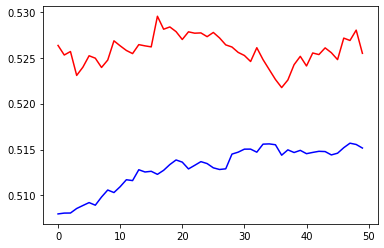

In [8]:
plt.plot(y_test[y_test.shape[1] - 1], color='red', label='Actual Prices')
plt.plot(predictions[predictions.shape[1] - 1], color='blue', label='Predicted Prices')